<a href="https://colab.research.google.com/github/nile649/CUDA_Tutorials/blob/master/cuda_chp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will now start our journey into GPU programming with an overview of Amdahl's Law.
Amdahl's Law is a simple but effective method to estimate potential speed gains we can get
by offloading a program or algorithm onto a GPU; this will help us determine whether it's
worth our effort to rewrite our code to make use of the GPU. We will then go over a brief
review of how to profile our Python code with the cProfile module, to help us find the
bottlenecks in our code.

An individual GPU core is
actually quite **simplistic**, and at a disadvantage when compared to a modern individual
CPU core, which use many fancy engineering tricks, such as branch prediction to reduce
the latency of computations. Latency refers to the beginning-to-end duration of performing
a single computation.

The power of the GPU derives from the fact that there are many, many more cores than in a
CPU, which means a huge step forward in throughput. Throughput here refers to the
number of computations that can be performed simultaneously


---



**A GPU is like a very wide city road that is
designed to handle many slower-moving cars at once (high throughput, high latency),
whereas a CPU is like a narrow highway that can only admit a few cars at once, but can get
each individual car to its destination much quicker (low throughput, low latency).**

---



Before we begin to program a parallel version of a given algorithm, we often start by
coming up with an estimate of the potential speedup that parallelization would bring to our
task. This can help us determine whether it is worth expending resources and time writing
a parallelization of our program or not.

---
**Using Amdahl's Law**
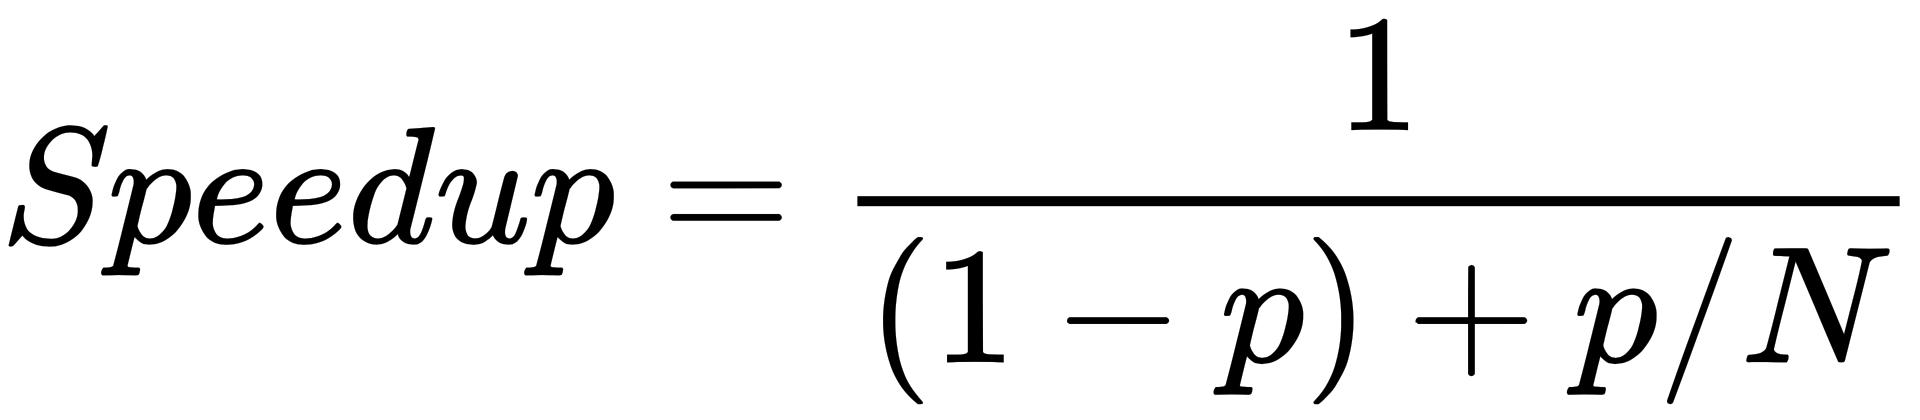

---



It only requires knowledge of the parallelizable proportion of
execution time for code in our original serial program, which is referred to as p, and the
number of processor cores N that we have available.
The proportion of execution time for code that is not parallelizable in this
case is always 1 – p, so we only need to know p.

In [1]:
!python --version

Python 3.6.9


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [1]:
import numpy as np

In [4]:
np.complex64(1+2j)

(1+2j)

Mandelbrot Plot

In [13]:
from time import time
import matplotlib
#this will prevent the figure from popping up
matplotlib.use('Agg')

from matplotlib import pyplot as plt
import numpy as np


def simple_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):
    
    real_vals = np.linspace(real_low, real_high, width)
    imag_vals = np.linspace(imag_low, imag_high, height)
        
    # we will represent members as 1, non-members as 0.
    
    mandelbrot_graph = np.ones((height,width), dtype=np.float32)
    
    for x in range(width):
        
        for y in range(height):
            
            c = np.complex64( real_vals[x] + imag_vals[y] * 1j  )            
            z = np.complex64(0)
            
            for i in range(max_iters):
                
                z = z**2 + c
                
                if(np.abs(z) > upper_bound):
                    mandelbrot_graph[y,x] = 0
                    break
                
    return mandelbrot_graph



In [16]:
from time import time
import matplotlib
# the following will prevent the figure from popping up
matplotlib.use('Agg')
from matplotlib import pyplot as plt


if __name__ == '__main__':
    
    t1 = time()
    mandel = simple_mandelbrot(512,512,-2,2,-2,2,256, 2)
    t2 = time()
    mandel_time = t2 - t1
    
    t1 = time()
    fig = plt.figure(1)
    plt.imshow(mandel, extent=(-2, 2, -2, 2))
    plt.savefig('mandelbrot.png', dpi=fig.dpi)
    t2 = time()
    
    dump_time = t2 - t1
    print( 'It took {} seconds to calculate the Mandelbrot graph.'.format(mandel_time))
    print('It took {} seconds to dump the image.'.format(dump_time))

It took 20.395868062973022 seconds to calculate the Mandelbrot graph.
It took 0.15669965744018555 seconds to dump the image.


It took 20.395868062973022 seconds to calculate the Mandelbrot graph.
It took 0.15669965744018555 seconds to dump the image.

So we can see that plot generation is independent process thus can be parallelized which 99% of the process time.

According to Amdahls law, 
1/(0.01+0.99/640(1050 cores) -> ~86% speedup